In [1]:
import os
import sys
import pandas
from tqdm import tqdm
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
from torch.utils.data import DataLoader, Dataset
from torch.nn import modules
from torch import nn
import torch
from torchsummaryX import summary
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [3]:
from bsa.dataset.data_loader import load_raw_data, preprocess_data, splitting_function

In [4]:
import random

seed = 3407
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Configurations

# Dataset

In [5]:
raw_data, raw_labels = load_raw_data("../data/data_for_bankruptcy_prediction_no_lags_corrected.csv")
x, y = preprocess_data(raw_data, raw_labels, horizon=3)
x_train, x_test, y_train, y_test = splitting_function(x, y, 0.05)

/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)


In [6]:
# Verify
print("Training features shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Testing features shape: ", x_test.shape)
print("Testing labels shape: ", y_test.shape)

Training features shape:  (57399, 324)
Training labels shape:  (57399, 4)
Testing features shape:  (2673, 324)
Testing labels shape:  (2673, 4)


In [7]:
class CompanyDataset(Dataset):
    def __init__(self, x : pandas.DataFrame, y : pandas.DataFrame) -> None:
        super().__init__()
        
        self.x = x.values
        self.y = y.values[:, 3]
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [8]:
train_data = CompanyDataset(x_train, y_train)
test_data = CompanyDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [9]:
for i, (x, y) in enumerate(train_loader):
    x : torch.Tensor = x
    print(x.isnan().any())
    print(x.shape)
    print(y.shape)
    break

tensor(False)
torch.Size([32, 324])
torch.Size([32])


# Network

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, input_feature) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_feature, 256),
            nn.Sigmoid(),

            nn.Linear(256, 256),
            nn.GELU(),

            nn.Linear(256, 256),
            nn.GELU(),

            nn.Linear(256, 256),
            nn.GELU(),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

In [23]:
model = MLP(x.shape[1]).to(device)
summary(model, x.to(device))

                   Kernel Shape Output Shape   Params Mult-Adds
Layer                                                          
0_layers.Linear_0    [324, 256]    [32, 256]    83.2k   82.944k
1_layers.Sigmoid_1            -    [32, 256]        -         -
2_layers.Linear_2    [256, 256]    [32, 256]  65.792k   65.536k
3_layers.GELU_3               -    [32, 256]        -         -
4_layers.Linear_4    [256, 256]    [32, 256]  65.792k   65.536k
5_layers.GELU_5               -    [32, 256]        -         -
6_layers.Linear_6    [256, 256]    [32, 256]  65.792k   65.536k
7_layers.GELU_7               -    [32, 256]        -         -
8_layers.Linear_8      [256, 1]      [32, 1]    257.0     256.0
9_layers.Sigmoid_9            -      [32, 1]        -         -
----------------------------------------------------------------
                        Totals
Total params          280.833k
Trainable params      280.833k
Non-trainable params       0.0
Mult-Adds             279.808k


/home/tonyzou/anaconda3/envs/torch-2.0/lib/python3.10/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_layers.Linear_0,"[324, 256]","[32, 256]",83200.0,82944.0
1_layers.Sigmoid_1,-,"[32, 256]",NaN,NaN
2_layers.Linear_2,"[256, 256]","[32, 256]",65792.0,65536.0
3_layers.GELU_3,-,"[32, 256]",NaN,NaN
4_layers.Linear_4,"[256, 256]","[32, 256]",65792.0,65536.0
5_layers.GELU_5,-,"[32, 256]",NaN,NaN
6_layers.Linear_6,"[256, 256]","[32, 256]",65792.0,65536.0
7_layers.GELU_7,-,"[32, 256]",NaN,NaN
8_layers.Linear_8,"[256, 1]","[32, 1]",257.0,256.0


In [24]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, maximize=False)

In [25]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    train_loss = 0
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        y_pred = model(x).view(-1)

        loss = criterion(y_pred, y)

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(train_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))
        
        batch_bar.update()

        loss.backward()

        optimizer.step()

    batch_bar.close()

    return train_loss / len(train_loader)

In [26]:
def eval(model, val_loader, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    
    predicts = []
    y_all = []
    
    total_loss = 0

    for i, (x, y) in enumerate(val_loader):
        x, y = x.to(device), y.to(device)

        with torch.inference_mode():
            y_pred = model(x).view(-1)
            
            loss = criterion(y_pred, y)

        predicts.append(y_pred)
        y_all.append(y)

        total_loss += loss.item()

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))))
        batch_bar.update()

    predicts = torch.cat(predicts, dim=0).cpu().detach().numpy()
    y_all = torch.cat(y_all, dim=0).cpu().detach().numpy()

    auc = roc_auc_score(y_all, predicts)
    
    return total_loss / len(val_loader), auc, predicts, y_all

In [27]:
for i in range(3):
    train_loss = train(model, train_loader, criterion, optimizer)
    loss, auc, predicts, y_all = eval(model, valid_loader, criterion)
    print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (i + 1, 3, train_loss))
    print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f \tAUC: %.4f'
                      % (i + 1, 3, loss, auc))

[TRAIN] 	Epoch [1/3] 	Loss: 0.1400
[VAL] 	Epoch [1/3] 	Loss: 0.1640 	AUC: 0.8109


[TRAIN] 	Epoch [2/3] 	Loss: 0.1220
[VAL] 	Epoch [2/3] 	Loss: 0.1319 	AUC: 0.8406


[TRAIN] 	Epoch [3/3] 	Loss: 0.1136
[VAL] 	Epoch [3/3] 	Loss: 0.1267 	AUC: 0.8466


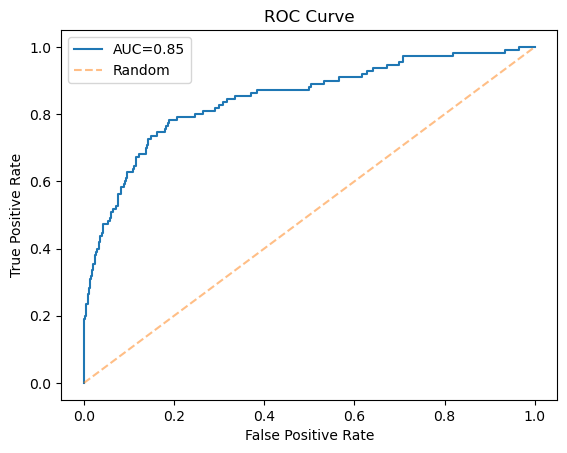

In [28]:
fpr, tpr, thresholds = roc_curve(y_all, predicts)


plt.plot(fpr, tpr, label=f'AUC={auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()